In [3]:
from automate_evaluation import automate_evaluation

stream_file_folder = "/Users/xiaodong/Desktop/UOX-simulations/simulation-29"

weights_list = [
    (10, -10, 10, 10, 10, -10)
]

lattice = "oI"  # Pearson Symbol read from .cell file first letter for lattice type and second for centering

automate_evaluation(stream_file_folder, weights_list, lattice)


Evaluating multiple stream files with weights: (10, -10, 10, 10, 10, -10)


Processing chunks in UOXsim_-512_-512.stream: 100%|██████████| 100/100 [00:41<00:00,  2.42chunk/s]


Combined metrics CSV written to /Users/xiaodong/Desktop/UOX-simulations/simulation-29/combined_metrics_IQM_SUM_10_-10_10_10_10_-10.csv
Best results stream file written to /Users/xiaodong/Desktop/UOX-simulations/simulation-29/best_results_IQM_SUM_10_-10_10_10_10_-10.stream
Writing .sol file from stream: /Users/xiaodong/Desktop/UOX-simulations/simulation-29/best_results_IQM_SUM_10_-10_10_10_10_-10.stream
Total number of indexed frames : 64


Optimal cutoff determined by K-Means: -22.0057
Event numbers and combined metric values to be cut off:
Event 2.0: Combined Metric = -17.9150
Event 6.0: Combined Metric = -0.2410
Event 20.0: Combined Metric = 10.5261
Event 21.0: Combined Metric = -3.0779
Event 22.0: Combined Metric = 3.0770
Event 28.0: Combined Metric = 35.5216
Event 39.0: Combined Metric = -18.7201
Event 43.0: Combined Metric = -18.0145
Event 48.0: Combined Metric = -14.2906
Event 51.0: Combined Metric = 1.3016
Event 52.0: Combined Metric = 4.8687
Event 66.0: Combined Metric = -3.9674
Event 72.0: Combined Metric = 9.1304
Event 82.0: Combined Metric = -21.6831
Event 84.0: Combined Metric = -6.7341

Cut-off events and their metrics have been written to: /Users/xiaodong/Desktop/UOX-simulations/simulation-1/cutoff_events_with_metrics.csv


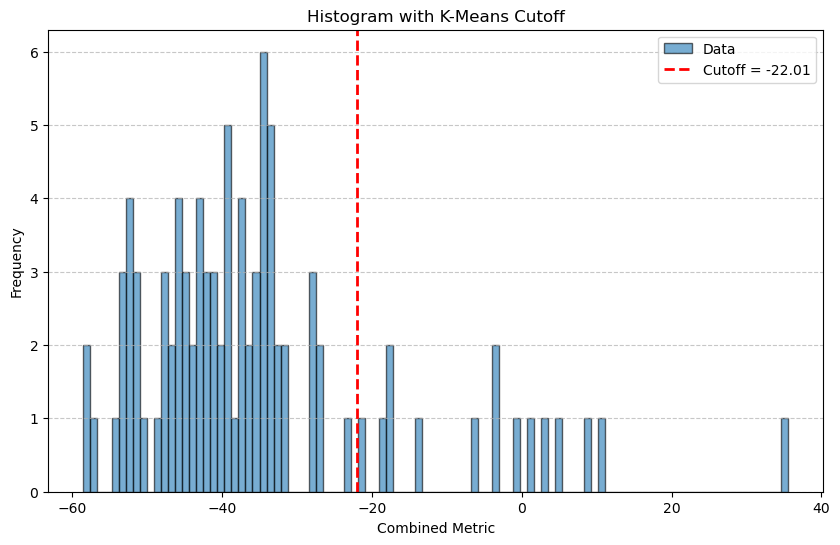

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load your data
csv_path = f"{stream_file_folder}/combined_metrics_IQM_SUM_10_-10_10_10_10_-10.csv"
df = pd.read_csv(csv_path)

# Group by event_number and get the minimum combined_metric for each event.
# This preserves the event_number as the index.
grouped_series = df.groupby("event_number")["combined_metric"].min()

# Reshape the values for clustering (each value in its own row)
grouped_values = grouped_series.values.reshape(-1, 1)

# Apply K-Means with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(grouped_values)
labels = kmeans.labels_
centers = kmeans.cluster_centers_.flatten()

# Since lower combined_metric is better, we want to flag the cluster with the higher center.
# The cluster with the higher center (worse metrics) is the one to cut off.
cutoff_label = np.argmax(centers)

# Compute a cutoff threshold as the mean of the two centers.
# This threshold is a rough boundary between the clusters.
sorted_centers = np.sort(centers)
cutoff = np.mean(sorted_centers)
print(f"Optimal cutoff determined by K-Means: {cutoff:.4f}")

# Identify the events that belong to the "cut off" cluster (i.e. those with higher combined_metric)
cutoff_mask = labels == cutoff_label
cutoff_events = grouped_series[cutoff_mask].index.tolist()
cutoff_metrics = grouped_series[cutoff_mask].values.tolist()

print("Event numbers and combined metric values to be cut off:")
for event, metric in zip(cutoff_events, cutoff_metrics):
    print(f"Event {event}: Combined Metric = {metric:.4f}")

# Optionally, write out the cut-off events and their combined metric values to a CSV file.
output_df = pd.DataFrame({
    "event_number": cutoff_events,
    "combined_metric": cutoff_metrics
})
output_csv_path = f"{stream_file_folder}/cutoff_events_with_metrics.csv"
output_df.to_csv(output_csv_path, index=False)
print(f"\nCut-off events and their metrics have been written to: {output_csv_path}")

# Plot the histogram with the cutoff threshold indicated
plt.figure(figsize=(10, 6))
plt.hist(grouped_values, bins=100, edgecolor='black', alpha=0.6, label='Data')
plt.axvline(cutoff, color='red', linestyle='dashed', linewidth=2, label=f'Cutoff = {cutoff:.2f}')
plt.title("Histogram with K-Means Cutoff")
plt.xlabel("Combined Metric")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
